Smoothing Contours
==================

Demonstrate how to smooth contour values from a higher resolution
model field.

By: Kevin Goebbert

Date: 13 April 2017

Do the needed imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import scipy.ndimage as ndimage

from metpy.units import units
from netCDF4 import num2date
from siphon.catalog import TDSCatalog

Set up netCDF Subset Service link

In [2]:
# Specify our date/time of product desired
dt = datetime(2016, 4, 16, 18)

# Construct the URL for our THREDDS Data Server Catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/model-namanl-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'namanl_218_{dt:%Y%m%d}_{dt:%H}00_000.grb'].subset()

# Create our NCSS query with desired specifications
query = ncss.query()
query.time(dt)
query.add_lonlat()
query.variables('Geopotential_height_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Obtain the data we've queried for
data = ncss.get_data(query)

Pull apart the data

In [3]:
# Get dimension names to pull appropriate variables
dtime = data.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data.variables['Geopotential_height_isobaric'].dimensions[2]
dlon = data.variables['Geopotential_height_isobaric'].dimensions[3]

# Get lat and lon data, as well as time data and metadata
lats = data.variables['lat'][:]
lons = data.variables['lon'][:]
lons[lons > 180] = lons[lons > 180] - 360

# Need 2D lat/lons for plotting, do so if necessary
if lats.ndim < 2:
    lons, lats = np.meshgrid(lons, lats)

# Determine the level of 500 hPa
levs = data.variables[dlev][:]
lev_500 = np.where(levs == 500)[0][0]

# Create more useable times for output
times = data.variables[dtime]
vtimes = num2date(times[:].squeeze(), times.units)

# Pull out the 500 hPa Heights
hght = units.meter * data.variables['Geopotential_height_isobaric'][:].squeeze()
uwnd = units('m/s') * data.variables['u-component_of_wind_isobaric'][:].squeeze()
vwnd = units('m/s') * data.variables['v-component_of_wind_isobaric'][:].squeeze()

# Calculate the magnitude of the wind speed in kts
sped = mpcalc.wind_speed(uwnd, vwnd).to('knots')

Set up the projection for LCC

In [4]:
plotcrs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
datacrs = ccrs.PlateCarree(central_longitude=0.)

Subset and smooth

In [5]:
# Subset the data arrays to grab only 500 hPa
hght_500 = hght[lev_500]
uwnd_500 = uwnd[lev_500]
vwnd_500 = vwnd[lev_500]

# Smooth the 500-hPa geopotential height field
# Be sure to only smooth the 2D field
Z_500 = ndimage.gaussian_filter(hght_500, sigma=5, order=0)

Plot the contours

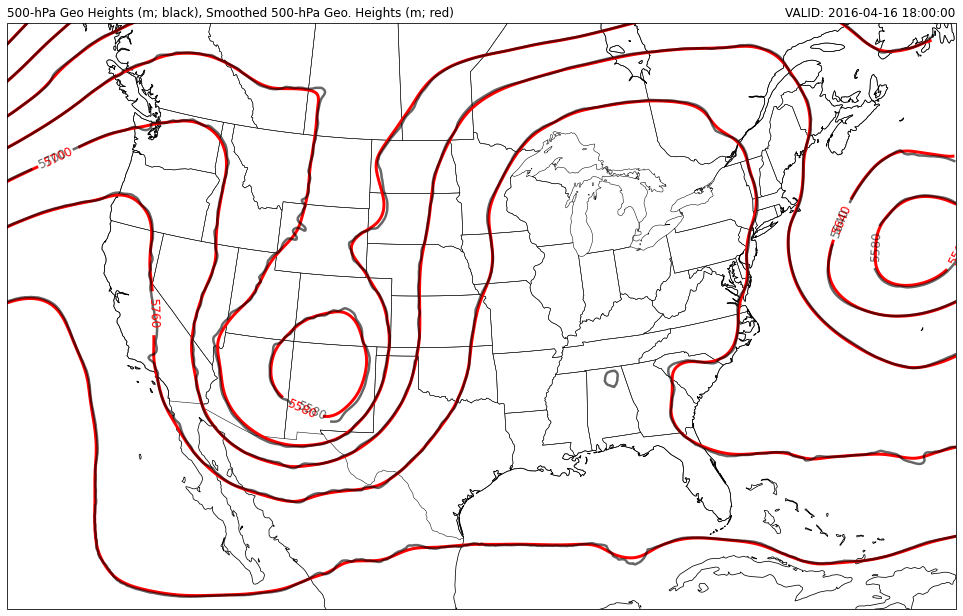

In [6]:
# Start plot with new figure and axis
fig = plt.figure(figsize=(17., 11.))
ax = plt.subplot(1, 1, 1, projection=plotcrs)

# Add some titles to make the plot readable by someone else
plt.title('500-hPa Geo Heights (m; black), Smoothed 500-hPa Geo. Heights (m; red)',
          loc='left')
plt.title(f'VALID: {vtimes}', loc='right')

# Set GAREA and add map features
ax.set_extent([-125., -67., 22., 52.], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Set the CINT
clev500 = np.arange(5100, 6000, 60)

# Plot smoothed 500-hPa contours
cs2 = ax.contour(lons, lats, Z_500, clev500, colors='red',
                 linewidths=3, linestyles='solid', transform=datacrs)
c2 = plt.clabel(cs2, fontsize=12, colors='red', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour the 500 hPa heights with labels
cs = ax.contour(lons, lats, hght_500, clev500, colors='black',
                linewidths=2.5, linestyles='solid', alpha=0.6, transform=datacrs)
cl = plt.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True);